# Prediction

In [2]:
import sys, os, glob
as_src_path = '/home/poulpos/pigs-documentary/as-fork'
as_pred_path = '/home/poulpos/pigs-documentary/as-fork/PREDICTION'
sys.path.insert(1, as_src_path)
sys.path.insert(1, as_pred_path)
result_path = "/home/poulpos/pigs-documentary/rennes"
prediction_path = os.path.join(result_path, "prediction")
prediction_template_path = os.path.join(as_src_path, "g5k", "prediction-template.ini")
flavor_path = os.path.join(as_src_path, "g5k")
inputs_path = '/home/poulpos/data/pigs/short_for_predic'

In [3]:
from g5k.config import generate_predict

In [4]:
import pandas as pd
import numpy as np
def read_output(file, start_line=1):
    with open(file) as f:
        lines = [line.rstrip() for i, line in enumerate(f) if i >= start_line - 1]
    df = pd.DataFrame(columns=["start", "end", "proba"])
    for line in lines:
        current = {}
        infos = line.split("|")
        if len(infos) >= 2 and infos[1] == "D":
            continue
        if len(infos) < 3:
            print(f"Can't understand the following line\n  {line}")
        infos = [e.strip() for e in infos[2].split(",")]
        for varval in infos:
            [var, val] = varval.split("=")
            if var == "time":
                [start, end] = val.split("-")
                current['start'] = float(start)
                current['end'] = float(end)
            elif var == "prob":
                current['proba'] = float(val)
        row = pd.DataFrame(data={k:[v] for k,v in current.items() if k != "lr"})
        df = pd.concat([df, row], ignore_index=True)
    return df

def aggregate(df, fun):
    timing = np.sort(pd.unique(pd.concat((df['start'],df['end']))))
    timing = pd.DataFrame(zip(timing[:-1], timing[1:]), columns=["start", "end"])
    full = pd.DataFrame(columns=["start", "end", "proba"], dtype=np.float64, data=[[0,0,0]])
    df["duration"] = df["end"] - df["start"]
    timing["duration"] = timing["end"] - timing["start"]
    df.sort_values(by='start', inplace=True)
    overlap_threshold = .8
    for i, slot in timing.iterrows():
        cut = df[(df['end'] >= slot.start) &  (df['start'] <= slot.end)]
        for j, wdw in cut.iterrows():
            dur_inter = min(slot.end, wdw.end) - max(slot.start, wdw.start)
            if dur_inter >= min(slot.duration, wdw.duration) * overlap_threshold:
                full = pd.concat([full, pd.DataFrame(data={'start': [slot.start], 'end': [slot.end], 'proba': [wdw.proba]})], ignore_index=True)
    
    full['mid'] = full.apply(lambda r: (r.end + r.start)/2, axis=1)
    meanf = full.groupby(by=["mid"]).agg(fun).rename(columns={'proba': 'mean_proba'})
    meanf.reset_index(inplace=True)
    return meanf

In [31]:
model_path = os.path.join(result_path, "2023-10-18")
model_farm = "BOX1-TRANS"
input_farm = "BOX1-FARMEIK"
flavor_name = "LF"

In [32]:
prediction_cfg = generate_predict(prediction_template_path,
                     prediction_path,
                     model_path, model_farm,
                     flavor_path, flavor_name,
                     inputs_path, input_farm)

In [33]:
from start_prediction import setup_prediction
predicter = setup_prediction(prediction_cfg['config']['file'])
predicter.init_logger()
predicter.read_config()
predicter.start_prediction()

2023-10-18 12:46:46,346 - training animal-spot - INFO - Config Data: {'log_dir': '/home/poulpos/pigs-documentary/rennes/prediction/log/BOX1-TRANS-LF', 'output_dir': '/home/poulpos/pigs-documentary/rennes/prediction/output/BOX1-TRANS-LF/BOX1-FARMEIK', 'src_dir': '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT', 'model_path': '/home/poulpos/pigs-documentary/rennes/2023-10-18/model/BOX1-TRANS-LF/ANIMAL-SPOT.pk', 'input_file': '/home/poulpos/data/pigs/short_for_predic/BOX1-FARMEIK', 'threshold': '0.75', 'debug': '', 'sequence_len': '0.26', 'hop': '0.10', 'batch_size': '1', 'num_workers': '1', 'no_cuda': '', 'min_max_norm': '', 'latent_extract': ''}
2023-10-18 12:46:46,346 - training animal-spot - INFO - Config Data: {'log_dir': '/home/poulpos/pigs-documentary/rennes/prediction/log/BOX1-TRANS-LF', 'output_dir': '/home/poulpos/pigs-documentary/rennes/prediction/output/BOX1-TRANS-LF/BOX1-FARMEIK', 'src_dir': '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT', 'model_path': '/home/poulpo

In [34]:
prediction_cfg['aspath']['output_dir']

'/home/poulpos/pigs-documentary/rennes/prediction/output/BOX1-TRANS-LF/BOX1-FARMEIK'

In [35]:
logs = glob.glob("*.log", root_dir=prediction_cfg['aspath']['output_dir'])
for i,l in enumerate(logs):
    print(f"{i} {l}")

0 calls-0000_predict_output.log
1 calls-1345_predict_output.log


In [41]:
log = logs[0]

In [42]:
df = read_output(os.path.join(prediction_cfg['aspath']['output_dir'], log), start_line=12)

<Axes: title={'center': 'calls-0000_predict_output.log'}, xlabel='start'>

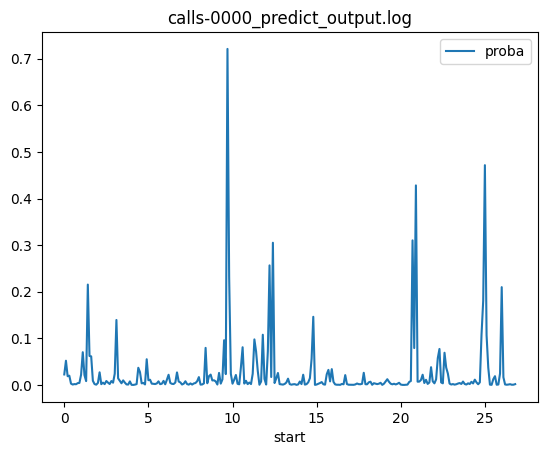

In [43]:
df.plot(x="start", y="proba", title=log)

<Axes: title={'center': 'calls-0000_predict_output.log'}, xlabel='mid'>

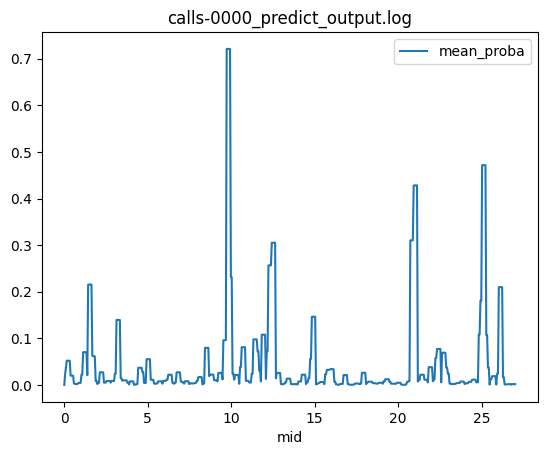

In [44]:
aggf = aggregate(df, 'max')
aggf.plot(x="mid", y="mean_proba", title=log)

In [45]:
prev_i = -1
start = 0
end = 0
for i,row in aggf[aggf["mean_proba"] > .6].iterrows():
    if i != prev_i + 1:
        print(f"{start} -> {end}    {end-start:.3f}")
        start = row.start
    end = row.end
    prev_i = i
print(f"{start} -> {end}")

0 -> 0    0.000
9.7 -> 9.96


In [173]:
".".join(["ewr", "er"])

'ewr.er'